# Necessary packages

In [49]:
import os
import cv2
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Exploratory Analysis

In [36]:
df = pd.read_csv("dataset/labels.csv")
df.profile_report()

Render HTML: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


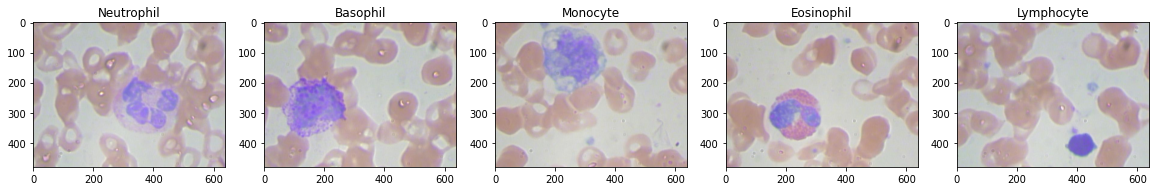

In [50]:
neutrophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00000.jpg"), 
    cv2.COLOR_BGR2RGB,
)
basophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00008.jpg"), 
    cv2.COLOR_BGR2RGB,
)
monocyte = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00015.jpg"),
    cv2.COLOR_BGR2RGB,
)
eosinophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00017.jpg"),
    cv2.COLOR_BGR2RGB,
)
lymphocyte = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00020.jpg"),
    cv2.COLOR_BGR2RGB,
)
fig, axs = plt.subplots(1, 5, figsize=(20, 7))
axs[0].imshow(neutrophil)
axs[0].title.set_text("Neutrophil")
axs[1].imshow(basophil)
axs[1].title.set_text("Basophil")
axs[2].imshow(monocyte)
axs[2].title.set_text("Monocyte")
axs[3].imshow(eosinophil)
axs[3].title.set_text("Eosinophil")
axs[4].imshow(lymphocyte)
axs[4].title.set_text("Lymphocyte")
plt.show()

# Model

In [473]:
class Classifier:
    def __init__(self) -> None:
        # Sets the target range for blue in HSV
        self.lb = np.array([90, 80, 160])
        self.ub = np.array([150, 140, 255])
        # Sets the target range for pink in HSV
        self.lp = np.array([140, 57, 59])
        self.up = np.array([165, 115, 185])
        # Bound areas
        self.bigBound = 650
        self.smallBound = 400
        pass

    def __filterBigCells(self):
        mask = cv2.inRange(self.img, self.lb, self.ub)
        return mask

    def __filterSmallCells(self):
        mask = cv2.inRange(self.img, self.lp, self.up)
        return mask

    def __findBigCells(self, contours):
        bigCells = []
        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > self.bigBound:
                bigCells += [contour]
        return bigCells
    
    def __findSmallCells(self, contours):
        smallCells = []
        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > self.smallBound:
                smallCells += [contour]
        return smallCells

    def __classify(self, bigCells, smallCells, isConvex, cntApprox):
        if isConvex:
            return "LYMPHOCYTE"
        elif len(smallCells) > 0 and len(bigCells) <= 2:
            return "EOSINOPHIL"
        elif len(smallCells) == 0 and len(bigCells) > 1:
            return "NEUTROPHIL"
        else:
            points = cv2.convexHull(cntApprox, False)
            if len(points) > 4:
                return "MONOCYTE"
            else:
                return "BASOPHIL"

    def run(self, imgPath):
        try:
            # Read image and convert to HSV
            self.img = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2HSV)
            # Isolate big cells (blue cells)
            mask = self.__filterBigCells()
            # Find contours of isolated big cells
            contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            # Filter out the small contours that are detected
            bigCells = self.__findBigCells(contours)
            # Isolate small cells (pink cells)
            mask = self.__filterSmallCells()
            # Find contours of isolated small cells
            contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            # Filter out the small contours that are detected
            smallCells = self.__findSmallCells(contours)
            # Smoothing contours for easier detection o Lymphocytes
            epsilon = cv2.arcLength(bigCells[0], True) * 0.03
            cntApprox = cv2.approxPolyDP(bigCells[0], epsilon, True)
            # Checking for convexity
            isConvex = cv2.isContourConvex(cntApprox)
            # Classify
            prediction = self.__classify(bigCells, smallCells, isConvex, cntApprox)
            return prediction
        except Exception as e:
            print(e)
            return "UNMATCH"


# Running the Model

In [474]:
images = os.listdir("./dataset/images")
predictions = []
classifier = Classifier()
for imageName in images:
    path = "./dataset/images/" + imageName
    predictions += [classifier.run(path)]
df["Predictions"] = predictions
df

,Image,Category,Predictions
0,0,NEUTROPHIL,NEUTROPHIL
1,1,NEUTROPHIL,NEUTROPHIL
2,2,NEUTROPHIL,NEUTROPHIL
3,3,NEUTROPHIL,NEUTROPHIL
4,4,NEUTROPHIL,LYMPHOCYTE
...,...,...,...
345,405,NEUTROPHIL,NEUTROPHIL
346,407,NEUTROPHIL,NEUTROPHIL
347,408,NEUTROPHIL,NEUTROPHIL
348,409,NEUTROPHIL,NEUTROPHIL


In [475]:
acc = accuracy_score(df["Category"], df["Predictions"])
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 50.57%


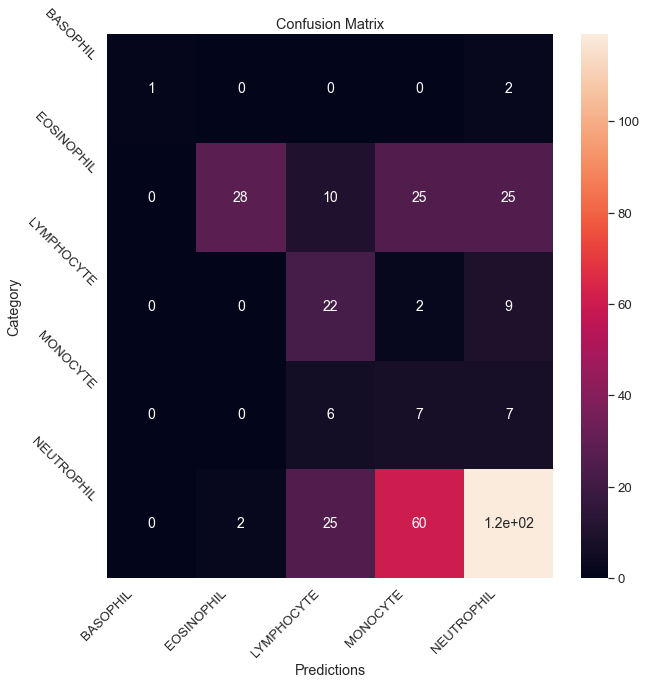

In [476]:
conf_matrix = confusion_matrix(df["Category"], df["Predictions"])
labels = list(pd.concat([df["Category"], df["Predictions"]]).unique())
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predictions")
ax.set_ylabel("Category")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.xaxis.set_ticklabels(sorted(labels), rotation=45)
ax.yaxis.set_ticklabels(sorted(labels), rotation=-45)
plt.show()
